In [1]:
%matplotlib inline

In [222]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.graphics import regressionplots
import yaml

### Load Data

The setup was to:

1. Add a timestamp to the ouput from the styx bridge, by adding `tw.header.stamp = rospy.get_rostime()` to `create_twist`.

2. Publish a constant throttle (and zero brake and zero steer) from the `dbw_node`.

3. Capture the output with `rostopic echo /current_velocity >throttle_0.X.yml`.

The notional rate for this topic is 50Hz, but we can see that there is quite a bit of variability:

```
$ rostopic hz /current_velocity
subscribed to [/current_velocity]
average rate: 50.998
	min: 0.000s max: 0.074s std dev: 0.02264s window: 48
```

In [203]:
DATA = {}
for filename in glob('throttle_*.yml'):
    throttle = re.match('throttle_([0-9.]+)[.]yml', filename).group(1)
    data = DATA[throttle] = []
    with open(filename, 'rb') as file:
        for point in yaml.load_all(file):
            data.append(point)

In [204]:
FRAME = pd.DataFrame([
    {
        'throttle': float(throttle),
        'seq': record['header']['seq'],
        'stamp_secs': record['header']['stamp']['secs'],
        'stamp_nsecs': record['header']['stamp']['nsecs'],
        'speed': record['twist']['linear']['x']
    }
    for throttle in DATA.keys()
    for record in DATA[throttle]
    if record is not None
])
FRAME[0:10]

,seq,speed,stamp_nsecs,stamp_secs,throttle
0,15424,9.343891e-07,515770912,1506743681,0.3
1,15425,9.343891e-07,521116971,1506743681,0.3
2,15426,9.343891e-07,524346113,1506743681,0.3
3,15427,1.115717e-06,528386116,1506743681,0.3
4,15428,1.420098e-06,540455102,1506743681,0.3
5,15429,9.554358e-07,608000993,1506743681,0.3
6,15430,9.554358e-07,612967967,1506743681,0.3
7,15431,9.430501e-07,617419004,1506743681,0.3
8,15432,9.430501e-07,622342109,1506743681,0.3
9,15433,9.435472e-07,633131027,1506743681,0.3


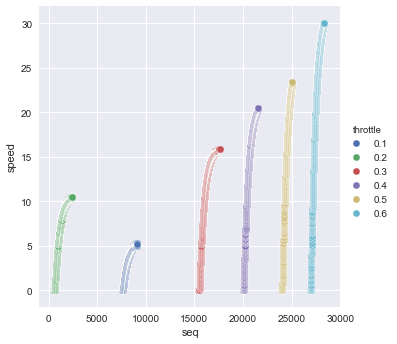

In [205]:
sns.pairplot(x_vars=['seq'], y_vars=['speed'], data=FRAME, hue='throttle', size=5)

### Trim the Data

We are not interested in the stationary bit at the start.

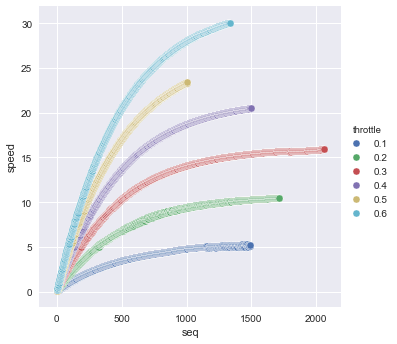

In [206]:
def clean_speeds(frame):
    frame = frame[frame.speed > 1e-1].copy()
    seq_starts = frame.groupby('throttle').seq.transform(min)
    frame.seq = frame.seq - seq_starts
    
    frame['stamp'] = frame.stamp_secs + frame.stamp_nsecs * 1e-9
    stamp_starts = frame.groupby('throttle').stamp.transform(min)
    frame.stamp = frame.stamp - stamp_starts
    
    return frame

CLEAN_FRAME = clean_speeds(FRAME)
sns.pairplot(x_vars=['seq'], y_vars=['speed'], data=CLEAN_FRAME, hue='throttle', size=5)

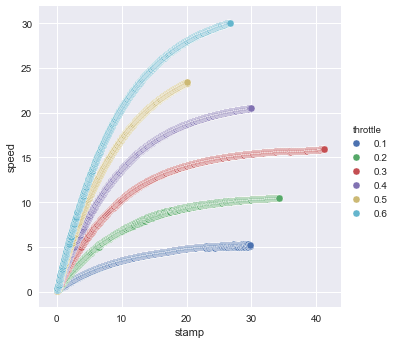

In [207]:
sns.pairplot(x_vars=['stamp'], y_vars=['speed'], data=CLEAN_FRAME, hue='throttle', size=5)

### Remove Duplicates

The data contain duplicate speed measurements, usually in runs of 2 or 3, but sometimes just single samples.

In [208]:
CLEAN_FRAME[0:10]

,seq,speed,stamp_nsecs,stamp_secs,throttle,stamp
103,0,0.143907,545815944,1506743683,0.3,0.000000
104,1,0.216012,617974042,1506743683,0.3,0.072158
105,2,0.216012,625133037,1506743683,0.3,0.079317
106,3,0.216012,629784107,1506743683,0.3,0.083968
107,4,0.264537,633327960,1506743683,0.3,0.087512
108,5,0.287322,647125959,1506743683,0.3,0.101310
109,6,0.384258,714715003,1506743683,0.3,0.168899
110,7,0.384258,718939065,1506743683,0.3,0.173123
111,8,0.384258,722727060,1506743683,0.3,0.176911
112,9,0.408293,728692054,1506743683,0.3,0.182876


My guess is that it is sampling at 50Hz from a variable that is being updated at a lower frequency. To correct for this, the simplest approach seems to me to be to take the mean timestamp for each speed value.

In [209]:
def deduplicate_frame(frame):
    max_speeds = frame.groupby(['throttle', 'speed']).stamp.transform(np.mean)
    return frame[frame.stamp == max_speeds].copy()
    
DEDUP_FRAME = deduplicate_frame(CLEAN_FRAME)
DEDUP_FRAME['ds'] = DEDUP_FRAME.groupby('throttle').speed.diff()
DEDUP_FRAME['dt'] = DEDUP_FRAME.groupby('throttle').stamp.diff()
DEDUP_FRAME['acceleration'] = DEDUP_FRAME.ds / DEDUP_FRAME.dt
DEDUP_FRAME[DEDUP_FRAME.throttle == 0.1][0:10]

,seq,speed,stamp_nsecs,stamp_secs,throttle,stamp,ds,dt,acceleration
8245,3,0.112180,324906110,1506743526,0.1,0.013647,NaN,NaN,NaN
8254,12,0.210110,501669883,1506743526,0.1,0.190411,0.097929,0.176764,0.554013
8259,17,0.263042,595141887,1506743526,0.1,0.283883,0.052932,0.093472,0.566286
8260,18,0.291624,615742921,1506743526,0.1,0.304484,0.028583,0.020601,1.387434
8261,19,0.290822,639605998,1506743526,0.1,0.328347,-0.000802,0.023863,-0.033621
8265,23,0.317989,724275112,1506743526,0.1,0.413016,0.027167,0.084669,0.320858
8270,28,0.371348,826889038,1506743526,0.1,0.515630,0.053359,0.102614,0.519999
8279,37,0.456122,995711088,1506743526,0.1,0.684452,0.084774,0.168822,0.502149
8280,38,0.477158,19520998,1506743527,0.1,0.708262,0.021037,0.023810,0.883532
8285,43,0.532810,123613119,1506743527,0.1,0.812354,0.055652,0.104092,0.534642


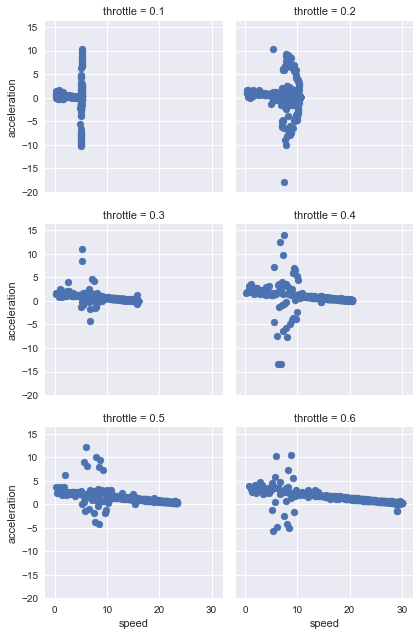

In [247]:
def plot_acceleration_vs_speed(frame):
    g = sns.FacetGrid(frame, col='throttle', col_wrap=2, sharex=True, sharey=True)
    g = g.map(plt.scatter, 'speed', 'acceleration')
plot_acceleration_vs_speed(DEDUP_FRAME)

### Jerk Filter

There is still a lot of noise, especially around lower speeds. Let's see if we can apply some filtering. The noisy changes in acceleration probably have very large jerk, so we should be able to filter out a lot of those.

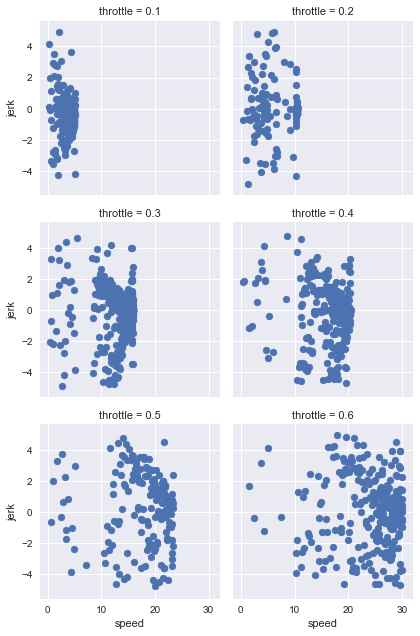

In [254]:
MAX_JERK = 5

def smooth_speeds(frame):
    frame['jerk'] = frame.groupby('throttle').acceleration.diff() / frame.dt
    return frame[frame.jerk.abs() < MAX_JERK]

SMOOTH_FRAME = smooth_speeds(DEDUP_FRAME)

def plot_jerk_vs_speed():
    g = sns.FacetGrid(SMOOTH_FRAME, col='throttle', col_wrap=2, sharex=True, sharey=True)
    g = g.map(plt.scatter, 'speed', 'jerk')
plot_jerk_vs_speed()

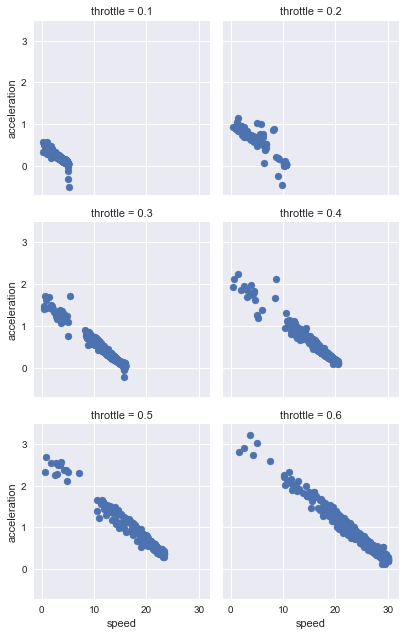

In [255]:
plot_acceleration_vs_speed(SMOOTH_FRAME)

### Fitting Models

So, we can see quite a lot of noise but also some fairly clear trend lines --- as speed increases, the acceleration obtained for a given throttle value decreases. Let's try to fit some models.

In [257]:
result = sm.ols(formula="throttle ~ acceleration + speed", data=SMOOTH_FRAME).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               throttle   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.144e+05
Date:                Sat, 30 Sep 2017   Prob (F-statistic):               0.00
Time:                        15:01:54   Log-Likelihood:                 5094.6
No. Observations:                1806   AIC:                        -1.018e+04
Df Residuals:                    1803   BIC:                        -1.017e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0009      0.001      1.144      0.253        -0.001     0.002
acceleration     0.1787      0.001    255.775      0.000         0.177     0.180
speed            0.0186   4.53e-05    411.468      0.000         0.019     0.019
==============================================================================
Omnibus:                      426.833   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21784.719
Skew:                          -0.057   Prob(JB):                         0.00
Kurtosis:                      20.014   Cond. No.                         40.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

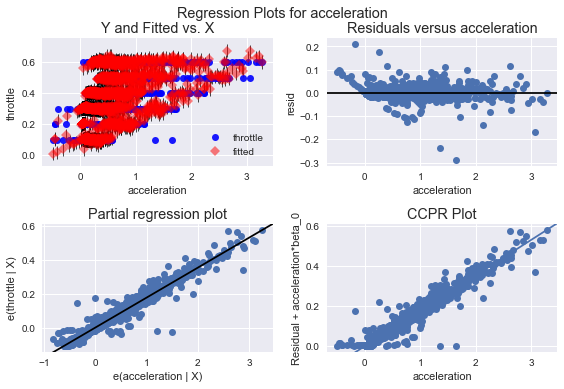

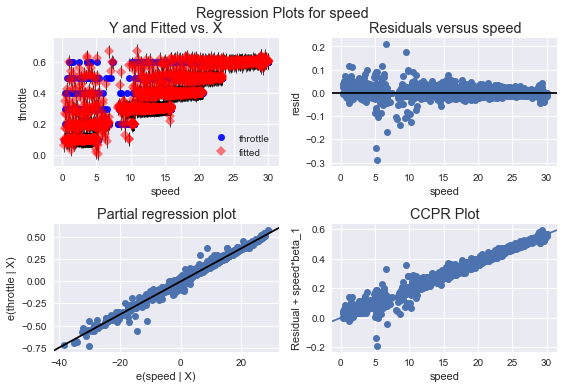

In [253]:
regressionplots.plot_regress_exog(result, 0)
regressionplots.plot_regress_exog(result, 1)
None

### Conclusion

However, when I use these factors in the simulator, it consistently under-accelerates relative to what I measured here, by about a factor of two, even on the straight. The PID controller therefore consistently saturates on the acceleration limit of 1m/s^2.